# Graphs

Compute random graphs and statistics from the tournesol dataset

## 1. Init or update Tournesol dataset (Todo once every week)

- Download zip from https://api.tournesol.app/exports/all/
- Extract zip 

## 2. Init or update Youtube cache (if tournesol dataset was updated)

Run script `py src/rndstats.py (-t <TOURNESOL_DATASET_PATH>) (-c <YTDATA_CACHE_PATH>) (-u <USER>) --fetch`

## 3. Check and update Notebook variables

See bloc [2] below

In [2]:
# Imports
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime
from dateutil.relativedelta import relativedelta
from numpy import std

# Project imports
sys.path.insert(1, '../src')
from model.youtube_api import YTData
from model.comparisons import ComparisonFile, ComparisonLine
from model.collectivecriteriascores import CollectiveCriteriaScoresFile, CCSLine
from model.individualcriteriascores import IndividualCriteriaScoresFile


In [3]:
# Variables
YTDATA_CACHE_PATH='../data/YTData_cache.json'
TOURNESOL_DATASET_PATH='../data/tournesol_dataset_2023-12-25'

In [ ]:
# Constants
YTDATA = YTData()
try:
	YTDATA.load(YTDATA_CACHE_PATH)
except FileNotFoundError as e:
	pass

COMPARISONS = ComparisonFile(TOURNESOL_DATASET_PATH)
COLLECTIVE_SCORES = CollectiveCriteriaScoresFile(TOURNESOL_DATASET_PATH)
INDIVIDUAL_SCORES = IndividualCriteriaScoresFile(TOURNESOL_DATASET_PATH)

actives_4 50 [None, None, None, 2578, 1848, 1355, 951, 760, 719, 686, 662, 641, 530, 500, 502, 500, 514, 500, 470, 442, 414, 402, 415, 411, 424, 399, 340, 300, 241, 215, 208, 197, 378, 621, 805, 869, 773, 602, 438, 402, 377, 359, 349, 326, 301, 275, 291, 325, 322, 324]
[datetime.datetime(2023, 1, 9, 0, 0), datetime.datetime(2023, 1, 16, 0, 0), datetime.datetime(2023, 1, 23, 0, 0), datetime.datetime(2023, 1, 30, 0, 0), datetime.datetime(2023, 2, 6, 0, 0), datetime.datetime(2023, 2, 13, 0, 0), datetime.datetime(2023, 2, 20, 0, 0), datetime.datetime(2023, 2, 27, 0, 0), datetime.datetime(2023, 3, 6, 0, 0), datetime.datetime(2023, 3, 13, 0, 0), datetime.datetime(2023, 3, 20, 0, 0), datetime.datetime(2023, 3, 27, 0, 0), datetime.datetime(2023, 4, 3, 0, 0), datetime.datetime(2023, 4, 10, 0, 0), datetime.datetime(2023, 4, 17, 0, 0), datetime.datetime(2023, 4, 24, 0, 0), datetime.datetime(2023, 5, 1, 0, 0), datetime.datetime(2023, 5, 8, 0, 0), datetime.datetime(2023, 5, 15, 0, 0), datetime.date

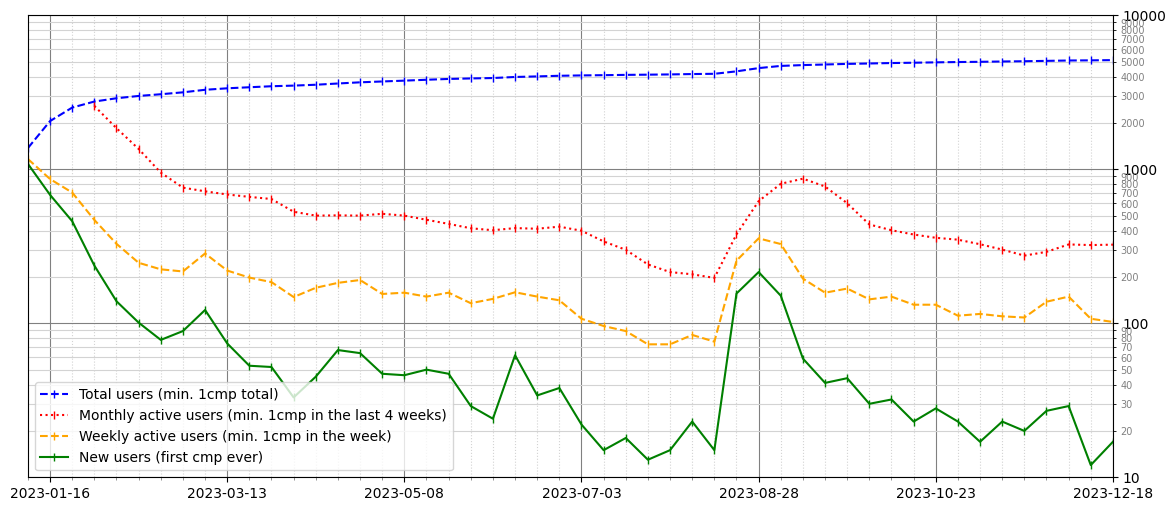

In [5]:
## User count over time

account_creation: dict[str,str] = dict() # user: date
actives: dict[str,set[str]] = dict() # date:{user, ...}

cut = (datetime.now() - relativedelta(years=1)).isoformat()
def fetch_users_data(line: ComparisonLine):
	if line.date < cut:
		return

	if (not line.user in account_creation) or account_creation[line.user] > line.date:
		account_creation[line.user] = line.date
	
	actives.setdefault(line.date, set()).add(line.user)
COMPARISONS.foreach(fetch_users_data)

l_dates: list[str] = sorted(actives.keys())

def usercount_graph():
	l_actives: list[int] = [len(actives[d]) for d in l_dates]
	l_total: list[int] = [len([a for a in account_creation if account_creation[a] <= d]) for d in l_dates]
	l_news: list[int] = [l_total[i] - l_total[i-1] for i in range(1,len(l_total))]
	l_datetimes: list[datetime] = [datetime.fromisoformat(k) for k in l_dates]

	l_actives_4: list[int] = [None]*4
	for i in range(4, len(l_dates)):
		monthly_usrs = set()
		for d in range(i-3, i+1):
			date = l_dates[d]
			monthly_usrs.update(actives[date])
		l_actives_4.append(len(monthly_usrs))

	l_datetimes.pop(0)
	l_total.pop(0)
	l_actives.pop(0)
	l_actives_4.pop(0)

	print('actives_4', len(l_actives_4), l_actives_4)

	fig, ax = plt.subplots()
	fig.set_size_inches(14, 6)
	ax.set_yscale('log')
	ax.set_ylim(ymin=10, ymax=10**math.ceil(np.log10(l_total[-1])))
	ax.set_xlim(xmin=l_datetimes[1], xmax=l_datetimes[-1])
	ax.yaxis.set_ticks_position('right')
	ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
	ax.yaxis.set_minor_formatter(mtick.ScalarFormatter())
	ax.yaxis.set_tick_params('minor', labelsize=7, labelcolor='gray')

	print(l_datetimes)

	ax.xaxis.set_ticks([l_datetimes[d] for d in range(len(l_datetimes)-1, 0, -8)])
	ax.xaxis.set_ticks(l_datetimes, minor=True)
	ax.xaxis.set_tick_params('minor', color='gray')
	ax.grid(visible=True, which='major', axis='y', color='gray')
	ax.grid(visible=True, which='minor', axis='y', color='lightgray')
	ax.grid(visible=True, which='major', axis='x', color='gray')
	ax.grid(visible=True, which='minor', axis='x', color='lightgray', linestyle=':')
	ax.plot_date(l_datetimes, l_total, xdate=True, color='blue', fmt='|--', label='Total users (min. 1cmp total)')
	ax.plot_date(l_datetimes, l_actives_4, xdate=True, color='red', fmt='|:', label='Monthly active users (min. 1cmp in the last 4 weeks)')
	ax.plot_date(l_datetimes, l_actives, xdate=True, color='orange', fmt='|--', label='Weekly active users (min. 1cmp in the week)')
	ax.plot_date(l_datetimes, l_news, xdate=True, fmt='|-', color='green', label='New users (first cmp ever)')
	ax.legend()
usercount_graph()

In [6]:
## Top videos
def top_videos():
	scores = COLLECTIVE_SCORES.get_vids_scores(criterion='largely_recommended')
	scores_ordered = sorted(scores.keys(), key=lambda k: scores[k], reverse=True)

	for i in range(10):
		vid = scores_ordered[i]
		score = scores[vid]
		txt = vid
		if vid in YTDATA.videos:
			txt = YTDATA.videos[scores_ordered[i]]
		print(f'Rank {i+1} (score={score}): {txt}')

top_videos()

Rank 1 (score=57.73): Science4All: Google a empoisonné la communauté scientifique, qui amplifie maintenant sa désinformation
Rank 2 (score=56.02): Chez Anatole: Arrêter la Viande ? L'IMPACT DE NOTRE ALIMENTATION
Rank 3 (score=55.69): BLAST, Le souffle de l'info: LES ALGORITHMES MENACENT-ILS L'HUMANITÉ ?
Rank 4 (score=55.69): Science4All: Trafiquant d'humains et marchand de haine #FacebookFiles
Rank 5 (score=55.25): Science4All: #ChatGPT, Top Gun, CR7, c'est... cool ? #CoolWashing #MuteNews
Rank 6 (score=54.31): Science4All: 4 aspects terrifiants de #DontLookUp
Rank 7 (score=53.95): Science4All: 5 IA surpuissantes
Rank 8 (score=53.94): Science4All: Le vrai danger avec #ChatGPT
Rank 9 (score=53.77): Osons Causer: Rénovation thermique : le meilleur investissement pour la France
Rank 10 (score=53.69): Science4All: Les réseaux sociaux sont dangereux. Très dangereux.


In [7]:
## Top creators
def top_creators():
	vid_scores = COLLECTIVE_SCORES.get_vids_scores(criterion='largely_recommended')
	creators: dict[str,dict[str,float]] = dict()

	for vid in vid_scores:
		creator = '#UNKNOWN CREATOR#'
		if vid in YTDATA.videos and YTDATA.videos[vid].channel:
			creator = YTDATA.videos[vid].channel.__str__()
		if not creator in creators:
			creators[creator] = dict()
		creators[creator][vid] = vid_scores[vid]

	creators_scores: dict[str, float] = {
		creator: sum(creators[creator].values())/len(creators[creator])
		for creator in creators
	}

	scores_ordered = sorted((c for c in creators_scores if len(creators[c]) > 1), key=lambda k: creators_scores[k], reverse=True)

	for i in range(len(scores_ordered)):
		creator = scores_ordered[i]
		vals=creators[creator].values()
		c_cnt=len(vals)
		c_min=min(vals)
		c_max=max(vals)
		c_avg=creators_scores[creator]
		c_std=std([float(v) for v in creators[creator].values()])

		if c_cnt == 1:
			print(f'{i+1:3d}. (avg={c_avg:0.2f}   1v): {creator}')
		else:
			print(f'{i+1:3d}. (avg={c_avg:0.2f} {c_cnt:3d}v): {creator}     (min={c_min:0.2f} max={c_max:0.2f} stdv={c_std:0.2f})')

top_creators()

  1. (avg=38.11  12v): ApresLaBiere     (min=0.96 max=51.83 stdv=16.36)
  2. (avg=33.20   5v): Mozilla     (min=9.15 max=45.97 stdv=13.11)
  3. (avg=32.72  31v): Spline LND     (min=6.22 max=49.38 stdv=12.78)
  4. (avg=32.59   3v): Amnesty International     (min=16.48 max=43.76 stdv=11.67)
  5. (avg=31.66  42v): Philoxime     (min=-5.55 max=52.37 stdv=15.58)
  6. (avg=30.92  26v): بكل بساطة – Kurzgesagt     (min=5.05 max=44.95 stdv=10.97)
  7. (avg=30.77  14v): Science4All (english)     (min=-1.40 max=51.58 stdv=18.61)
  8. (avg=29.85  27v): Em Poucas Palavras – Kurzgesagt     (min=8.69 max=43.59 stdv=11.50)
  9. (avg=29.37  26v): 한눈에 보는 세상 – Kurzgesagt     (min=5.26 max=44.54 stdv=12.13)
 10. (avg=28.80  26v): 世界をわかりやすく – Kurzgesagt     (min=4.63 max=45.55 stdv=11.07)
 11. (avg=27.81  31v): La Fabrique Sociale     (min=0.05 max=52.78 stdv=16.48)
 12. (avg=27.68  36v): Tout Simplement – Kurzgesagt     (min=-0.91 max=45.04 stdv=15.62)
 13. (avg=25.72  26v): आसान शब्दों में — Kurzgesagt 

In [8]:
## Users proximity
USER_PROX_MIN_VID = 50
USER_PROX_KEEP = 3 # Top x users having the best proximity to keep so that `len(user_prox[username]) <= USER_PROX_KEEP`
TOP_USER_PROX = 50

top_user_prox: list[tuple[str,str,float]] = list()
user_prox:dict[str,dict[str,float]] = dict() # [user1][user2] = similarity
indiv_scores = INDIVIDUAL_SCORES.get_scores(users=account_creation.keys()) # (score, uncertainty) = indiv_scores[user][video][criterion]

users = [u for u in indiv_scores if len(indiv_scores[u]) > USER_PROX_MIN_VID]

for i,u1 in enumerate(users[:-1]):
	if not u1 in indiv_scores:
		continue
	u1_scores = indiv_scores[u1] # (score, uncertainty) = u1_scores[video][criterion]
	u1_prox:dict[str,float] = user_prox.setdefault(u1, dict()) # proximity = u1_prox[u2]

	for u2 in users[i+1:]:
		if not u2 in indiv_scores:
			continue
		u2_scores = indiv_scores[u2] # (score, uncertainty) = u2_scores[video][criterion]

		vids_in_common = set(u1_scores.keys())
		vids_in_common.intersection_update(u2_scores.keys())

		# Compute proximity between u1 and u2
		user_sim = 0.0
		for vid in vids_in_common:
			vid_sim = 0.0
			common_criteria = set(u1_scores[vid].keys())
			common_criteria.intersection_update(u2_scores[vid].keys())
			for crit in common_criteria:
				u1s = (u1_scores[vid][crit][0] + 100)/100
				u2s = (u2_scores[vid][crit][0] + 100)/100
				vid_sim += 1 - (u1s - u2s)**2
			vid_sim /= (len(u1_scores[vid]) + len(u2_scores[vid]) - len(common_criteria))
			user_sim += vid_sim

		user_sim /= len(u1_scores) + len(u2_scores) - len(vids_in_common)

		# Assign proximities
		if user_sim > 0:
			u1_prox[u2] = user_sim
			user_prox.setdefault(u2, dict())[u1] = user_sim

	if u1_prox:
		top_keys = sorted(u1_prox.keys(), key=u1_prox.get, reverse=True)
		u1_prox = {u2: u1_prox[u2] for u2 in top_keys[:USER_PROX_KEEP]}
		
		top_user_prox.extend((u1_prox[u2],u1,u2) for u2 in u1_prox if u1 < u2)
		top_user_prox = sorted(top_user_prox, reverse=True)[:TOP_USER_PROX]

		# if len(u1_scores) > 200:
		# 	print(f"{u1} ({len(u1_scores)}v):  \t", end='')
		# 	for u2 in u1_prox:
		# 		print(f"{u2} ({u1_prox[u2]:0.2%})  \t", end='')
		# 	print(flush=True)

print()
print()

for (i, (sim,u1,u2)) in enumerate(top_user_prox, start=1):
	print(f"{i:2d}. {sim:6.2%} - {u1} & {u2}")




 1. 16.54% - aidjango & biscuissec
 2. 12.87% - Marlonelias & emily.baliki
 3. 12.67% - Marlonelias & TylerKlimos
 4. 12.28% - TylerKlimos & emily.baliki
 5. 11.41% - aidjango & white
 6. 11.32% - aidjango & lpfaucon
 7. 11.19% - joleenj & vero
 8. 11.15% - biscuissec & white
 9. 10.29% - biscuissec & lpfaucon
10.  9.45% - Anadore & Marlonelias
11.  9.36% - Zekk & aidjango
12.  8.43% - Pierre M & aidjango
13.  8.38% - ABX & Everyatis
14.  8.36% - Zekk & biscuissec
15.  8.19% - Zekk & white
16.  7.70% - Pierre M & biscuissec
17.  6.27% - emily.baliki & haekel
18.  6.26% - bastianlouis & biscuissec
19.  6.21% - TylerKlimos & lioneldeveaux
20.  6.17% - bastianlouis & white
21.  6.07% - lpfaucon & white
22.  5.91% - Anadore & emily.baliki
23.  5.88% - Pierre M & bastianlouis
24.  5.86% - Anadore & sebu
25.  5.85% - Allouette & MrChamo
26.  5.80% - Foebus & vero
27.  5.78% - Foebus & Tit0uan
28.  5.70% - K_D & xavichou
29.  5.58% - quentinG & smad
30.  5.45% - Mutre & tesseract
31.  5.41%

In [ ]:
# Estimate uncompared video notes for specific user according to users similarities

USER_RECOM = 'NatNgs'
RECOM_CRITERION = 'largely_recommended'
MIN_W = 0.05
IGNORE_VIDS: set[str] = {'GWyrwG_QGeI', 'utWMGi8HTjY', 'XhRbt3R41hs'}

def recommend_videos(recom_nb: int):
	# Proximities to other users
	recom_user_prox = user_prox[USER_RECOM] # proximity = recom_user_prox[u2]
	print('recom_user_prox:', len(recom_user_prox))

	# Scores of others
	# indiv_scores (score, uncertainty) = indiv_scores[user][video][criterion]
	print('indiv_scores:', len(indiv_scores))

	vid_scores: dict[str,tuple[float,float,float,int]] = dict() # (minestim_sum, maxestim_sum, total_weights) = vid_scores[vid]
	for u in recom_user_prox:
		w = recom_user_prox[u]
		unseen = set(indiv_scores[u].keys())
		unseen.difference_update(IGNORE_VIDS)
		unseen.difference_update(indiv_scores[USER_RECOM].keys())
		#unseen.intersection_update(indiv_scores[USER_RECOM].keys())
		for v in unseen:
			if not RECOM_CRITERION in indiv_scores[u][v]:
				continue
			##
			# if not v in vid_scores:
			# 	(score, uncertainty) = indiv_scores[USER_RECOM][v].get(RECOM_CRITERION,0.0)
			# 	minestim = max(-100, score - uncertainty)
			# 	maxestim = min(+100, score + uncertainty)
			# 	vid_scores[v] = (maxestim, minestim, 1, 0)
			##

			(max_sum, min_sum, weights, n) = vid_scores.get(v,(0.0, 0.0, 0.0, 0))
			(score, uncertainty) = indiv_scores[u][v][RECOM_CRITERION]

			minestim = max(-100, score - uncertainty)
			maxestim = min(+100, score + uncertainty)

			vid_scores[v] = (max_sum + w*maxestim, min_sum + w*minestim, weights+w, n+1)

	for v in list(vid_scores.keys()):
		(max_sum, min_sum, weights, n) = vid_scores[v]
		if n < 2 or weights <= MIN_W:
			vid_scores.pop(v)
			continue
		vid_scores[v] = ((max_sum+min_sum)/weights/2, round(max_sum/weights), round(min_sum/weights), weights, n)

	vid_recom = sorted(vid_scores.keys(), key=vid_scores.get, reverse=True)

	print(f'Recommending for {USER_RECOM}:')
	for v in vid_recom[:recom_nb]:
		(avg, max_sum, min_sum, weight, n) = vid_scores[v]
		print(f"- {v}: {min_sum:+4.0f} ~ {max_sum:+4.0f}🌻 (w={weight:0.2f} n={n})")

recommend_videos(10)


Polyfit: [0.6820619  0.49341344]


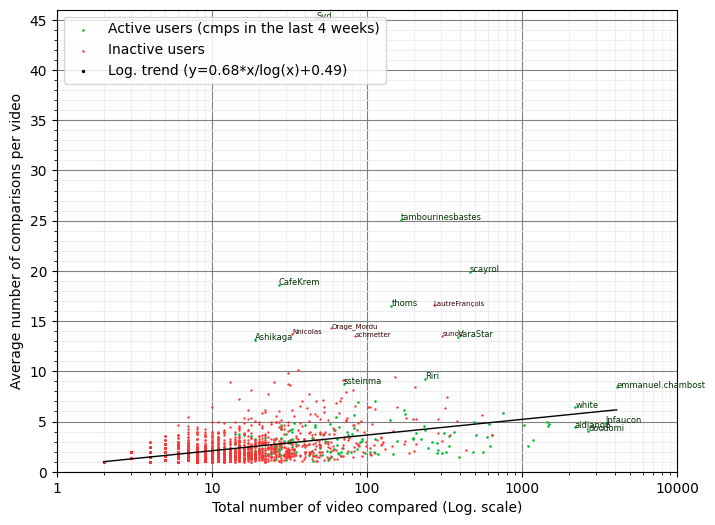

In [10]:
## Users comparisons graph
plt.rc('axes', unicode_minus=False)
def users_cmp_graph():
	comps:dict[str,int] = dict()
	videos:dict[str,set[str]] = dict()

	def fetch_users_data(line: ComparisonLine):
		if line.criterion != 'largely_recommended':
			return
		if not line.user in comps:
			comps[line.user] = 0
			videos[line.user] = set()
		
		comps[line.user] += 2
		videos[line.user].add(line.vid1)
		videos[line.user].add(line.vid2)

	COMPARISONS.foreach(fetch_users_data)

	uu = sorted(comps.keys())
	xx = [len(videos[u]) for u in uu]
	yy = [comps[u] / len(videos[u]) for u in uu]
	mx = max(xx)

	print()
	polyfit = np.polyfit(np.log(xx), yy, 1)
	print('Polyfit:', polyfit)

	fig, ax = plt.subplots()
	fig.set_size_inches(8, 6)

	#ax.set_yscale('log')
	ax.set_xscale('log')
	ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
	ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
	ax.set_xlim(xmin=1, xmax=10**math.ceil(math.log10(max(xx))))
	y_ticks_spacing = math.ceil((max(yy)-min(yy))/10)
	ax.yaxis.set_ticks(np.arange(0, (1+round(max(yy)/y_ticks_spacing))*y_ticks_spacing, y_ticks_spacing))
	ax.yaxis.set_ticks(np.arange(0, (1+round(max(yy))), 1), minor=True)
	ax.set_ylim(ymin=0, ymax=math.floor(max(yy))+1)
	ax.grid(visible=True, which='major', axis='both', color='gray')
	ax.grid(visible=True, which='minor', axis='both', color='#eee')
	ax.set_axisbelow(True)

	green = {u for u in uu if u in actives[l_dates[-1]] or u in actives[l_dates[-2]] or u in actives[l_dates[-3]] or u in actives[l_dates[-4]]}


	for i,u in enumerate(uu):
		if u in green and yy[i] > 8 or xx[i] > 2000:
		#if u in green and yy[i]*xx[i] > 800:
			ax.text(xx[i], yy[i], s=u, fontsize=6, color="#030")
		elif u not in green and yy[i] > 12:
		#elif u not in green and xx[i]*yy[i] > 800:
			ax.text(xx[i], yy[i], s=u, fontsize=5, color="#300")

	ax.scatter([xx[i] for i,u in enumerate(uu) if u in green],
			[yy[i] for i,u in enumerate(uu) if u in green],
			c='#00BB33', marker='.', s=3, label='Active users (cmps in the last 4 weeks)')
	ax.scatter([xx[i] for i,u in enumerate(uu) if not u in green],
			[yy[i] for i,u in enumerate(uu) if not u in green],
			c='#FF3333', marker='.', s=2, label='Inactive users')
	ax.scatter([], [], c="#000", s=2, label=f"Log. trend (y={polyfit[0]:0.2f}*x/log(x){polyfit[1]:+0.2f})")


	poly_xx = [2, mx]
	poly_yy = [1, polyfit[0]*math.log(mx)+polyfit[1]]
	ax.plot(poly_xx, poly_yy, color='#000', linewidth=1)


	# plt.title('How many comparisons every Tournesol users have done')
	ax.legend(loc='upper left')
	ax.set_ylabel('Average number of comparisons per video')
	ax.set_xlabel('Total number of video compared (Log. scale)')
	
users_cmp_graph()


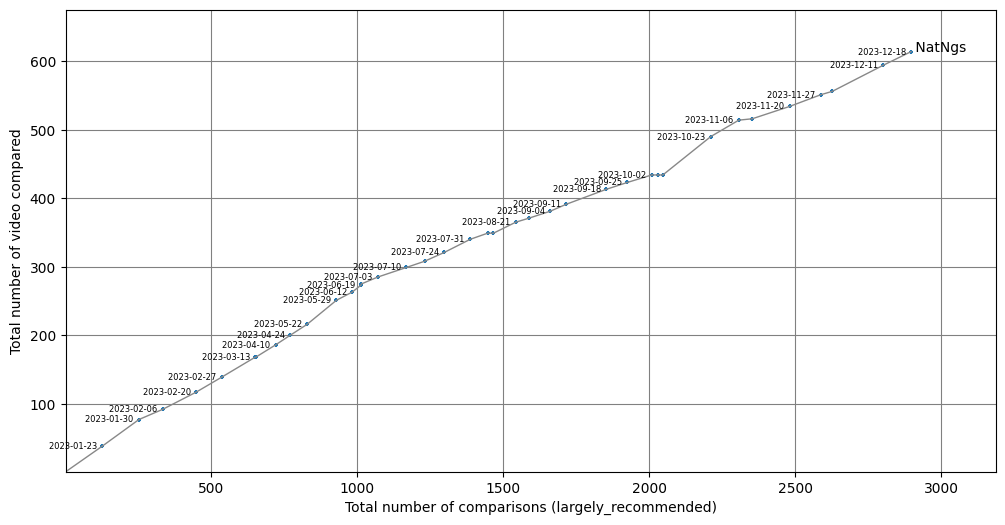

In [11]:
## User progression graph

USERS={'NatNgs'} #emmanuel.chambost lpfaucon white

def user_progress_graph():
	per_date:dict[str,dict[str,dict[str,int]]] = dict() # per_date[user][date] = {vid1: <nb comparisons>}

	def fetch_user_data(line: ComparisonLine):
		if line.criterion != 'largely_recommended' or (not line.user in USERS):
			return

		cmps = per_date.setdefault(line.user, dict()).setdefault(line.date, dict())
		cmps[line.vid1] = cmps.get(line.vid1, 0) + 1
		cmps[line.vid2] = cmps.get(line.vid2, 0) + 1
	COMPARISONS.foreach(fetch_user_data)

	tt = sorted({d for u in per_date for d in per_date[u].keys()})

	fig, ax = plt.subplots()
	fig.set_size_inches(12, 6)
	ax.grid(visible=True, which='major', axis='both', color='gray')
	ax.grid(visible=True, which='minor', axis='both', color='#eee')
	ax.set_axisbelow(True)

	def user_curve(USER: str):
		yy_set:set[str] = set()
		xx_sum=0
		xx = []
		yy = []
		for d in per_date[USER].keys():
			dt = per_date[USER][d]
			yy_set.update(dt.keys())
			xx_sum += sum(dt.values())
			xx.append(xx_sum)
			yy.append(len(yy_set))
			if len(xx) == 1 or yy[-1] >= yy[-2] + 10:
				ax.text(xx[-1], yy[-1], s=f'{d}  ', fontsize=6, verticalalignment='center', horizontalalignment='right')

		ax.scatter(xx, yy, marker='+', s=8)

		ax.plot(xx, yy, color='#888', linewidth=1)
		ax.plot([2,xx[0]], [1,yy[0]], color='#888', linewidth=1)
		ax.text(xx[-1], yy[-1], s=f' {USER}')
		return (max(xx), max(yy))

	mx = -1
	my = -1
	for user in USERS:
		max_x, max_y = user_curve(user)
		if max_x > mx:
			mx = max_x
		if max_y > my:
			my = max_y

	ax.set_ylim([1, math.ceil(my)*1.1])
	ax.set_xlim([1, math.ceil(mx)*1.1])

	# ax.set_xscale('log')
	# ax.xaxis.set_major_formatter(mtick.ScalarFormatter())

	# ax.set_yscale('log')
	# ax.yaxis.set_major_formatter(mtick.ScalarFormatter())

	# plt.title('How many comparisons every Tournesol users have done')
	ax.set_xlabel('Total number of comparisons (largely_recommended)')
	ax.set_ylabel('Total number of video compared')
user_progress_graph()


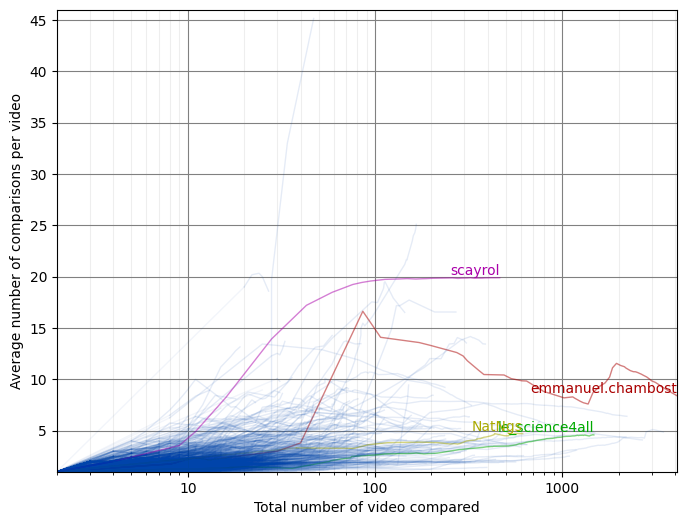

In [21]:
## Global progression graph

def global_progress_graph():
	per_date:dict[str,dict[str,dict[str,int]]] = dict() # per_date[user][date] = {vid1: <nb comparisons>}

	def fetch_user_data(line: ComparisonLine):
		if line.criterion != 'largely_recommended':
			return

		cmps = per_date.setdefault(line.user, dict()).setdefault(line.date, dict())
		cmps[line.vid1] = cmps.get(line.vid1, 0) + 1
		cmps[line.vid2] = cmps.get(line.vid2, 0) + 1
	COMPARISONS.foreach(fetch_user_data)

	tt = sorted({d for u in per_date for d in per_date[u].keys()})

	fig, ax = plt.subplots()
	fig.set_size_inches(8, 6)
	ax.grid(visible=True, which='major', axis='both', color='gray')
	ax.grid(visible=True, which='minor', axis='both', color='#eee')
	ax.set_axisbelow(True)

	def user_curve(user: str):
		xx_set:set[str] = set()
		yy_sum=0
		xx = []
		yy = []
		for dt in per_date[user].values():
			xx_set.update(dt.keys())
			yy_sum += sum(dt.values())
			xx.append(len(xx_set))
			yy.append(yy_sum / xx[-1])

		color = '#04a'
		alpha = 0.1
		if user == 'NatNgs': 
			color = '#aa0'
			alpha = 0.5
			ax.text(xx[-1], yy[-1], s=user, color=color, horizontalalignment='right', verticalalignment='bottom')
		elif user == 'le_science4all':
			color = '#0a0'
			alpha = 0.5
			ax.text(xx[-1], yy[-1], s=user, color=color, horizontalalignment='right', verticalalignment='bottom')
		elif user == 'scayrol': 
			color = '#a0a'
			alpha = 0.5
			ax.text(xx[-1], yy[-1], s=user, color=color, horizontalalignment='right', verticalalignment='bottom')
		elif user == 'emmanuel.chambost':
			color = '#a00'
			alpha = 0.5
			ax.text(xx[-1], yy[-1], s=user, color=color, horizontalalignment='right', verticalalignment='bottom')

		ax.plot(xx, yy, color=color, alpha=alpha, linewidth=1)
		ax.plot([2,xx[0]], [1,yy[0]], color=color, alpha=alpha/2, linewidth=1)
		return (max(xx), max(yy))

	mx = -1
	my = -1
	for user in per_date.keys():
		max_x, max_y = user_curve(user)
		if max_x > mx:
			mx = max_x
		if max_y > my:
			my = max_y

	ax.yaxis.set_ticks(np.arange(start=0, stop=my+1, step=5))
	ax.set_ylim([1, math.ceil(my)])
	ax.set_xlim([2, math.ceil(mx)])

	ax.set_xscale('log')
	ax.xaxis.set_major_formatter(mtick.ScalarFormatter())

	# plt.title('How many comparisons every Tournesol users have done')
	ax.set_ylabel('Average number of comparisons per video')
	ax.set_xlabel('Total number of video compared')

global_progress_graph()

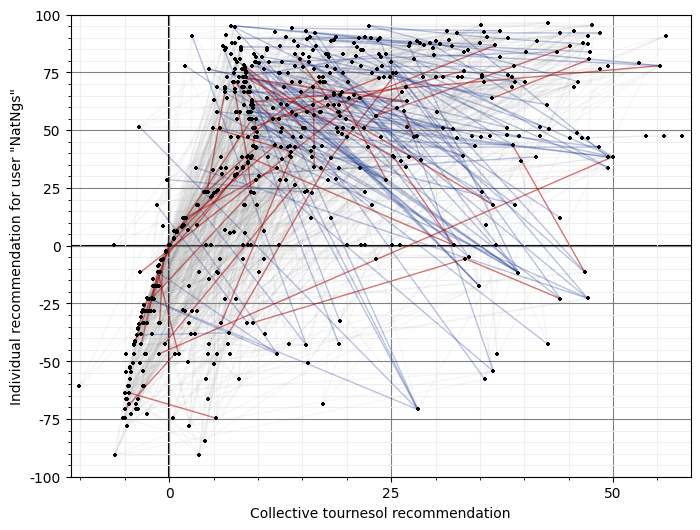

In [13]:
## User against global scores

USER='NatNgs'
CRITERION='largely_recommended'

def user_vs_global():
	uscores = INDIVIDUAL_SCORES.get_scores(criterion=CRITERION, users=[USER])[USER] # `(score, uncertainty) = out[video][criterion]`
	vids = sorted(uscores.keys())
	gscores = COLLECTIVE_SCORES.get_scores(criterion=CRITERION, vids=vids) # `(score, uncertainty) = out[video][criterion]`

	fig, ax = plt.subplots()
	fig.set_size_inches(8, 6)

	ax.grid(visible=True, which='major', axis='both', color='gray')
	ax.grid(visible=True, which='minor', axis='both', color='#eee')
	ax.set_axisbelow(True)

	ax.plot([-100,100], [0,0], color='#000', zorder=-1)
	ax.plot([0,0], [-100,100], color='#000', zorder=-1)

	xminmax = [0,0]
	def add_comparisons(line:ComparisonLine):
		if line.criterion != CRITERION or line.vid1 not in uscores or line.vid2 not in uscores:
			return
		if line.user == USER:
			color = None
			zorder = None
			if ((uscores[line.vid2][CRITERION][0] - uscores[line.vid1][CRITERION][0] > 10 and line.score < -1) \
				or (uscores[line.vid1][CRITERION][0] - uscores[line.vid2][CRITERION][0] > 10 and line.score > 1)):
				# 'Red' links: Individual score does not match with comparison direction (the one compared as to be recommended has a lower individual score)
				color = '#A008'
				zorder = 4
				# print(f"- {line.vid1} # {-line.score:+0d} # {line.vid2}")
				# print(f"  {YTDATA.videos.get(line.vid1,line.vid1)} (me:{uscores[line.vid1][CRITERION][0]:0.2f}, glob:{gscores[line.vid1][CRITERION][0]:0.2f})")
				# print(f"  {YTDATA.videos.get(line.vid2,line.vid2)} (me:{uscores[line.vid2][CRITERION][0]:0.2f}, glob:{uscores[line.vid2][CRITERION][0]:0.2f})\n")
			elif (gscores[line.vid2][CRITERION][0] - gscores[line.vid1][CRITERION][0] > 10 and line.score < -1) \
				or (gscores[line.vid1][CRITERION][0] - gscores[line.vid2][CRITERION][0] > 10 and line.score > 1):
				# 'Blue' links (individual score corresponds to comparison direction, but not collective score)
				color = '#0284'
				zorder = 3
			else:
				# 'Gray' links (individual score AND collective score corresponds to comparison direction)
				color = '#8881' # '#0821'
				zorder = 2

			ax.plot(
				[gscores[line.vid1][CRITERION][0], gscores[line.vid2][CRITERION][0]], # Global scores
				[uscores[line.vid1][CRITERION][0], uscores[line.vid2][CRITERION][0]], # User scores
				color=color,
				linewidth=1,
				zorder=zorder
			)
		xminmax[0] = min(xminmax[0], gscores[line.vid1][CRITERION][0], gscores[line.vid2][CRITERION][0])
		xminmax[1] = max(xminmax[1], gscores[line.vid1][CRITERION][0], gscores[line.vid2][CRITERION][0])
		"""else:
			if (gscores[line.vid2][CRITERION][0] > gscores[line.vid1][CRITERION][0] and line.score <= 0) \
				or (gscores[line.vid2][CRITERION][0] < gscores[line.vid1][CRITERION][0] and line.score >= 0):
				ax.plot(
					[gscores[line.vid1][CRITERION][0], gscores[line.vid2][CRITERION][0]], # Global scores
					[uscores[line.vid1][CRITERION][0], uscores[line.vid2][CRITERION][0]], # User scores
					color='#8041',
					linewidth=1
				)"""
	COMPARISONS.foreach(add_comparisons)

	# plt.title('How many comparisons every Tournesol users have done')
	ax.set_xlim(xmin=xminmax[0]-1, xmax=xminmax[1]+1)
	ax.xaxis.zorder = 1
	ax.xaxis.set_ticks([t for t in [-100, -75, -50, -25, 0, 25, 50, 75, 100] if t >= xminmax[0] and t <= xminmax[1]])
	ax.xaxis.set_ticks([t for t in range(-100,101,5) if t >= xminmax[0] and t <= xminmax[1]], minor=True)
	ax.set_xlabel('Collective tournesol recommendation')

	ax.set_ylim([-100, 100])
	ax.yaxis.zorder = 1
	ax.yaxis.set_ticks([-100, -75, -50, -25, 0, 25, 50, 75, 100])
	ax.yaxis.set_ticks(list(range(-100,101,5)), minor=True)
	ax.set_ylabel('Individual recommendation for user "' + USER + '"')

	# Plot videos as black dots
	ax.scatter(
		[gscores[v][CRITERION][0] for v in vids], # Global scores
		[uscores[v][CRITERION][0] for v in vids], # User scores
		c='#000', marker='+', s=8,
		zorder=10
	)
user_vs_global()

/home/Nathael.Nogues/.local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from current font.
  func(*args, **kwargs)
/home/Nathael.Nogues/.local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  func(*args, **kwargs)
/home/Nathael.Nogues/.local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from current font.
  func(*args, **kwargs)
/home/Nathael.Nogues/.local/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from current font.
  func(*args, **kwargs)
/home/Nathael.Nogues/.local/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/Nathael.Nogues/.local/lib/python3.9/

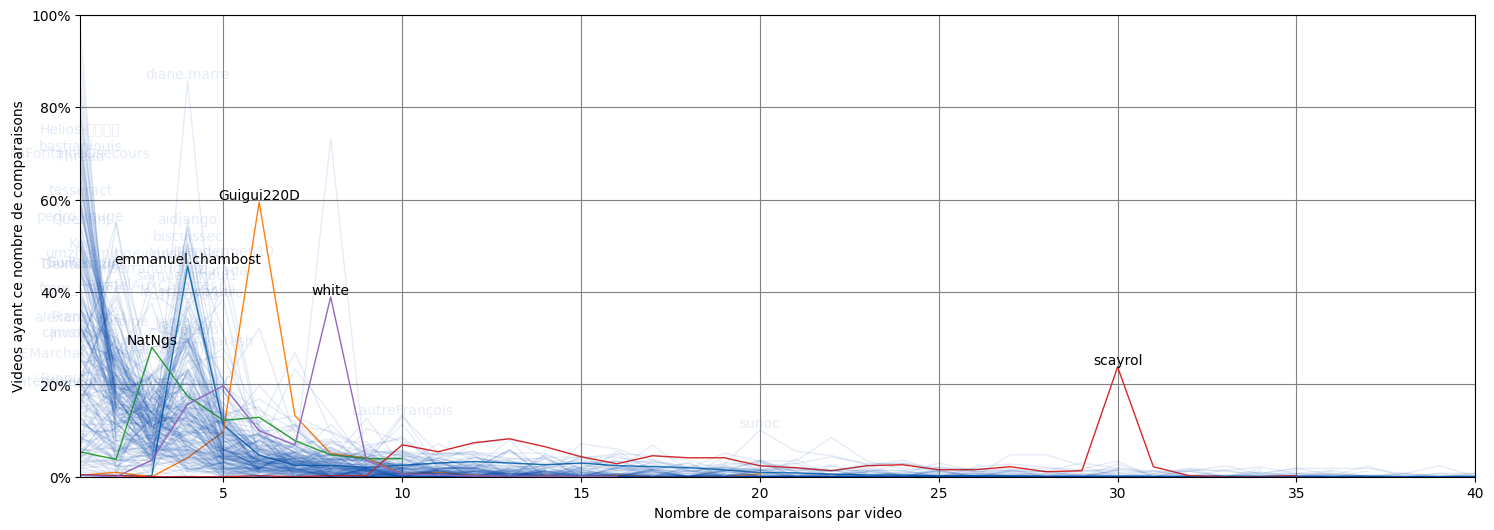

In [14]:
## Users comparisons count graph
plt.rc('axes', unicode_minus=False)
def cmp_count_graph():
	users_vieos: dict[str,dict[str,int]] = dict() # data[user][vid] = nbComparisons
	def fetch_user_data(line: ComparisonLine):
		if line.criterion != 'largely_recommended':
			return

		cmps = users_vieos.setdefault(line.user, dict())
		cmps[line.vid1] = cmps.get(line.vid1, 0) + 1
		cmps[line.vid2] = cmps.get(line.vid2, 0) + 1
	COMPARISONS.foreach(fetch_user_data)
	# print(users_vieos['NatNgs'])

	# Aggregating
	users_nbcomp:dict[str,dict[int,int]] = dict() # data[user][nbcomp] = nb videos compared <nbcomp> times
	for u in users_vieos:
		users_nbcomp[u] = dict()
		for vid,cnt in users_vieos[u].items():
			users_nbcomp[u][cnt] = users_nbcomp[u].get(cnt,0) + 1
	users_vieos.clear()
	users_vieos = None # flush
	# print(users_nbcomp['NatNgs'])


	# Preparing plot
	fig, ax = plt.subplots()
	fig.set_size_inches(18, 6)
	ax.grid(visible=True, which='major', axis='both', color='gray')
	ax.grid(visible=True, which='minor', axis='both', color='#eee')
	ax.set_axisbelow(True)

	def user_curve(user: str):
		xx = []
		yy = []
		maxy = 0
		summ = sum(users_nbcomp[user].values())
		if summ < 50: # Skip users with less than 10 comparisons
			return (-1,-1)
		
		for i in range(min(users_nbcomp[user].keys()), max(users_nbcomp[user].keys())+1):
			xx.append(i)
			y = users_nbcomp[user].get(i,0) / summ
			yy.append(y)
			if y > yy[maxy]:
				maxy = len(yy)-1

		color = '#04a'
		alpha = 0.1
		if user in ['NatNgs', 'scayrol', 'sumoc', 'white', 'Guigui220D', 'emmanuel.chambost']:
			color = None
			alpha = 1
			# print(user, ', '.join([f'{cmp}: {cnt}' for cmp,cnt in sorted(users_nbcomp[user].items())]))

		if alpha > 0.1 or summ > 200 or max(xx) > 75:
			ax.text(xx[maxy], max(yy), s=user, color=color, alpha=alpha, horizontalalignment='center', verticalalignment='bottom')
		ax.plot(xx, yy, color=color, alpha=alpha, linewidth=1)
		return (max(xx), max(yy))

	mx = -1
	my = -1
	for user in users_nbcomp.keys():
		max_x, max_y = user_curve(user)
		if max_x > mx:
			mx = max_x
		if max_y > my:
			my = max_y

	ax.set_xlim(xmin=1,xmax=40)

	ax.set_ylim(ymin=0, ymax=1)
	ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

	# plt.title('How many comparisons every Tournesol users have done')
	ax.set_xlabel('Nombre de comparaisons par video')
	ax.set_ylabel('Videos ayant ce nombre de comparaisons')

cmp_count_graph()

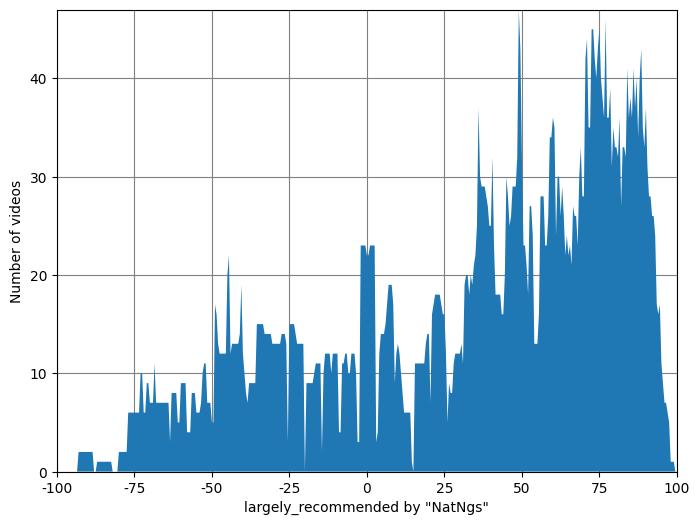

In [15]:
def user_histogram(USER: str):
	## User against global scores
	CRITERION='largely_recommended'
	uscores = INDIVIDUAL_SCORES.get_scores(criterion=CRITERION, users=[USER])[USER] # `(score, uncertainty) = out[video][criterion]`
	vids = sorted(uscores.keys())

	LINEAR=5
	xx=sorted([uscores[v][CRITERION][0] for v in vids])
	yy=range(len(xx))

	fig, ax = plt.subplots()
	fig.set_size_inches(8, 6)

	ax.grid(visible=True, which='major', axis='both', color='gray')
	ax.grid(visible=True, which='minor', axis='both', color='#eee')
	ax.set_axisbelow(True)

	ax.set_xlim(xmin=-100, xmax=100)
	# ax.plot(xx,yy)

	etl = 5
	xx2=[x/10.0 for x in range(-1000, 1001,etl)]
	yy2=[len([a for a in xx if a >= (x-etl/2) and a <= (x+etl/2)]) for x in xx2]
	ax.set_ylim(ymin=0,ymax=max(yy2))
	ax.fill(xx2,yy2)

	# counts, bins = np.histogram(xx, bins=100)
	# ax.hist(bins[:-1], bins, weights=counts)

	# plt.title('How many comparisons every Tournesol users have done')
	ax.set_xlabel('largely_recommended by "' + USER + '"')
	ax.set_ylabel('Number of videos')

user_histogram('NatNgs')


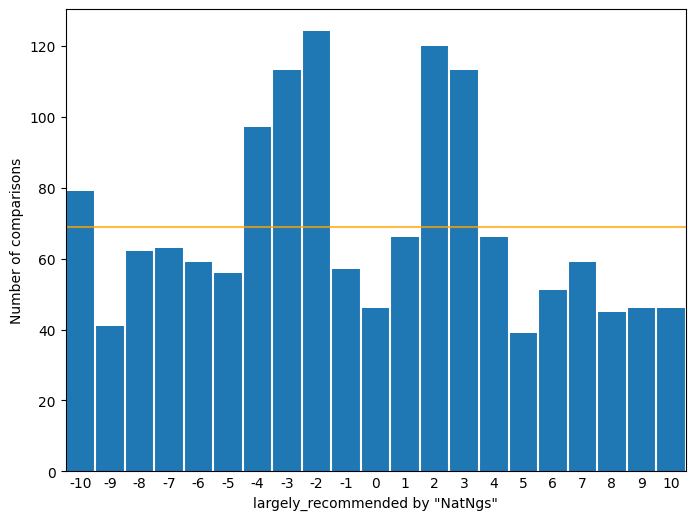

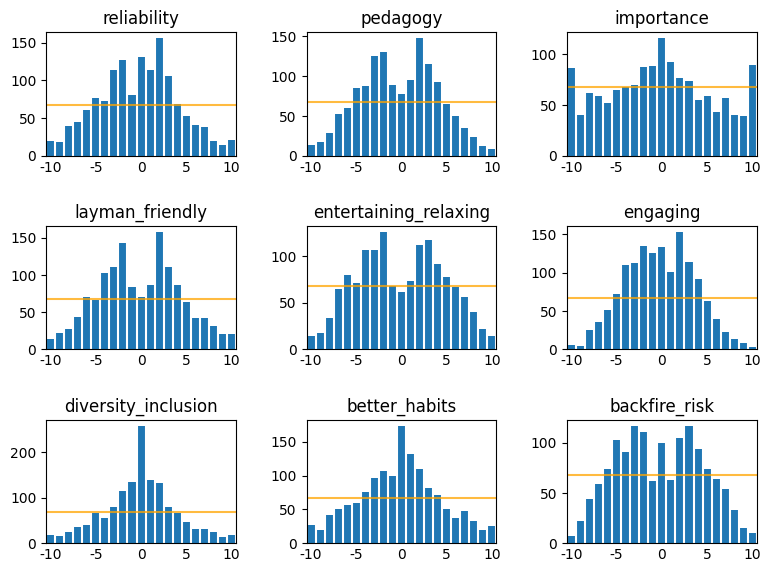

In [16]:
from matplotlib.axes import Axes

USER='NatNgs'

def user_histogram(ax: Axes, USER: str, CRITERION: str, title: bool=False):
	votes = []
	def parseComparisons(line: ComparisonLine):
		if line.user == USER and line.criterion == CRITERION:
			votes.append(line.score)
	COMPARISONS.foreach(parseComparisons)

	ax.set_axisbelow(True)

	ax.set_xlim(xmin=-10.5, xmax=10.5)
	ax.xaxis.set_ticks(range(-10,11,1 if title else 5))
	ax.tick_params(axis='x', length=0)

	counts, bins = np.histogram(votes, bins=21)
	bins = [i/10.0 for i in range(-105,106,10)]
	ax.hist(bins[:-1], bins, weights=counts, align='mid')
	for i in bins: # Plot white lines to separate columns
		ax.axvline(i, color='white')

	# plt.title('How many comparisons every Tournesol users have done')
	if title:
		ax.set_xlabel(CRITERION + ' by "' + USER + '"')
		ax.set_ylabel('Number of comparisons')
	else:
		ax.set_title(CRITERION)

	# Plot orange line on average value
	ax.axhline(np.average(counts), color='orange', alpha=.75)


fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
user_histogram(ax, USER, 'largely_recommended', True)

fig, ax = plt.subplots(3,3)
user_histogram(ax[0][0], USER, 'reliability')
user_histogram(ax[0][1], USER, 'pedagogy')
user_histogram(ax[0][2], USER, 'importance')
user_histogram(ax[1][0], USER, 'layman_friendly')
user_histogram(ax[1][1], USER, 'entertaining_relaxing')
user_histogram(ax[1][2], USER, 'engaging')
user_histogram(ax[2][0], USER, 'diversity_inclusion')
user_histogram(ax[2][1], USER, 'better_habits')
user_histogram(ax[2][2], USER, 'backfire_risk')
fig.tight_layout()
fig.set_size_inches(8, 6)

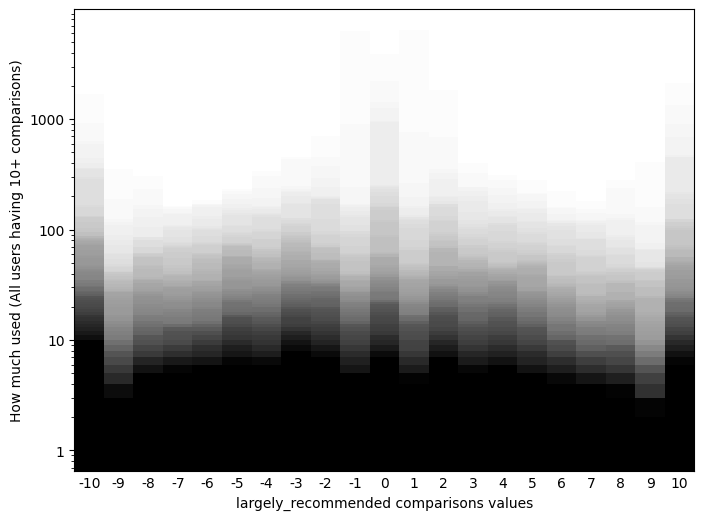

In [17]:
def allusers_histogram():
	## User against global scores
	CRITERION='largely_recommended'

	votes: dict[str,list[int]] = dict()
	overall = list()
	def parseComparisons(line: ComparisonLine):
		if line.criterion == CRITERION:
			votes.setdefault(line.user, list()).append(line.score)
			overall.append(line.score)
	COMPARISONS.foreach(parseComparisons)

	# Remove users with less than 10 comparisons
	for u in list(votes):
		if len(votes[u]) < 10:
			votes.pop(u)
		elif min(votes[u]) == max(votes[u]):
			votes.pop(u)

	# Prepare plot
	fig, ax = plt.subplots()
	fig.set_size_inches(8, 6)


	# ax.set_ylim(ymin=0, ymax=1)
	# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
	ax.set_yscale('log')
	ax.yaxis.set_major_formatter(mtick.ScalarFormatter())

	ax.set_axisbelow(True)
	ax.set_xlim(xmin=-10.5, xmax=10.5)
	ax.xaxis.set_ticks(range(-10,11))
	ax.tick_params(axis='x', length=0)

	# Plot histograms
	alpha = max(2/len(votes), 0.01)
	bins = [i/10.0 for i in range(-105,106,10)]
	for u in votes:
		ax.hist(bins[:-1], bins, weights=np.histogram(votes[u], bins=21, density=False)[0], color='black', alpha=alpha)

	# Plot white lines to separate columns
	#for i in bins:
	#	ax.axvline(i, color='white')
	
	# Plot collective histogram
	# ax.hist(bins[:-1], bins, weights=np.histogram(overall, bins=21, density=True)[0], color='blue', histtype='step')

	# plt.title('How many comparisons every Tournesol users have done')
	ax.set_xlabel('largely_recommended comparisons values')
	ax.set_ylabel('How much used (All users having 10+ comparisons)')

allusers_histogram()

In [18]:
# Videos having comparisons from 2 users from channel having videos with high score
def recom_2contrib():
	data:dict[str,dict[str,set[str]]] = dict() # channel, vid, [users]
	def extractcmps(line: ComparisonLine):
		if line.criterion != 'largely_recommended':
			return
		if not line.vid1 in YTDATA.videos or YTDATA.videos[line.vid1].channel is None \
			or not line.vid2 in YTDATA.videos or YTDATA.videos[line.vid2].channel is None:
			return
		
		data.setdefault(YTDATA.videos.get(line.vid1).channel.id, dict()).setdefault(line.vid1, set()).add(line.user)
		data.setdefault(YTDATA.videos.get(line.vid2).channel.id, dict()).setdefault(line.vid2, set()).add(line.user)
	COMPARISONS.foreach(extractcmps)

	to_recom:dict[str,set[str]] = dict() # [channel] = {vid}
	is_recom:dict[str,set[str]] = dict() # [channel] = {vid}
	for c in data:
		for vid in data[c]:
			if len(data[c][vid]) < 3:
				if len(data[c][vid]) == 2:
					to_recom.setdefault(c,set()).add(vid)
			else:
				is_recom.setdefault(c,set()).add(vid)
		if not c in to_recom and c in is_recom:
			is_recom.pop(c)
		elif not c in is_recom and c in to_recom:
			to_recom.pop(c)

	vscores: dict[str,float] = {v:0 for c in to_recom for v in to_recom[c]}
	recom_val: dict[str,list[float]] = {c:[] for c in is_recom}
	def extractscores(line: CCSLine):
		if line.criterion != 'largely_recommended':
			return
		if line.video in vscores:
			vscores[line.video] = line.score
			return
		if not line.video in {v for c in is_recom for v in is_recom[c]}:
			return
		if not line.video in YTDATA.videos or YTDATA.videos.get(line.video).channel is None:
			return
		channel = YTDATA.videos.get(line.video).channel.id
		if not channel in recom_val:
			return
		recom_val[channel].append(line.score)
	COLLECTIVE_SCORES.foreach(extractscores)

	vfinal = {v:sum(recom_val[c])*vscores[v]/len(to_recom[c]) for c in to_recom for v in to_recom[c]}
	for v in sorted(vfinal, key=vfinal.get, reverse=True)[:250]:
		print(f'{vfinal[v]:10.2f} - [{v}]', YTDATA.videos.get(v))

print('Suggestion of videos having only 2 public Contributors')
recom_2contrib()

Suggestion of videos having only 2 public Contributors
   8502.96 - [ehULekS95UA] بكل بساطة – Kurzgesagt: الآثار الجانبية للقاحات - ما مدى ارتفاع المخاطر؟
   8311.01 - [HPXQaMfk1HE] بكل بساطة – Kurzgesagt: غيِّر حياتك - خطوة صغيرة في كل مرة
   7528.27 - [-mzb3_oa_TU] Tout Simplement – Kurzgesagt: Et si nous atomisions la Lune ?
   7385.27 - [iivprdEFSvs] 世界をわかりやすく – Kurzgesagt: 人生を変える–一度に少しずつ
   7303.11 - [mFzz_gRJbTE] 世界をわかりやすく – Kurzgesagt: 存在しないはずの（でも存在する）ウイルス
   6696.46 - [iIpSWGLtufI] Philoxime: Une loi climat, à quoi bon ?
   6193.36 - [cWTn73BZs8c] Fouloscopie: La foule peut-elle battre Kasparov aux échecs ? | EPISODE #6
   6091.31 - [6jYg3n_ePE8] Spline LND: Bug Mental #16 - YOUTUBE ET LE TOUR DE LA NAPPE
   5030.39 - [1xvF9iYh4yQ] Vlanx: Est-ce que tout achat CRÉE DE LA VALEUR ?
   4768.40 - [mnkI4cNmNlw] Stupid Economics: Peut-on mesurer le racisme?
   4579.19 - [4ycuZqKuKa8] Em Poucas Palavras – Kurzgesagt: O Paradoxo de Fermi — Soluções e Ideias — Onde estão todos os aliení